# 1. Introuction

This notebook outlines the creation, compilation, and training of multiple ViT networks using both transfer learning and regular learning of the whole backbone. Transfer learning allows leveraging pre-trained models to achieve high accuracy with reasonable training times by fine-tuning for the specific task at hand, in this case for food recognition. For the sake of fair comparison, the traning process of the models will be configured with the same number of epochs, learning rate, and regularization. The values of these parameters have been determined based of previous experimentation.

The following table summarize the models:

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | Yes | 60 | 0.0001 | No | 85.9M |
| 2 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | Yes | 60 | 0.0001 | No | 86.7M |
| 3 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | None | Yes | 60 | 0.0001 | No | 303.4M |
| 4 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | 1024 | Yes | 60 | 0.0001 | No | 304.5M |
| 5 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 20 | 0.00001 | No | 85.9M |
| 6 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 20 | 0.00001 | No | 86.7M |
| 7 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |
| 8 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 1024 | No | 10 | 0.0001 | CosineAnnealingLR | 86.7M |
| 9 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | Multiple | No | 10 | 0.0001 | CosineAnnealingLR | 87.9M |
| 10 | Large | 224x224 | 16x16 | 24 | 1024 | 4096 | 16 | None | No | 10 | 0.00001 | No | 303.4M |
| 11 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.0001 | CosineAnnealingLR | 85.9M |
| 12 | Base | 256x256 | 16x16 | 12 | 768 | 3072 | 12 | None | No | 10 | 0.000001 | No | XM |

The transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [ ]:
#!pip install onnxruntime
#!pip install onnxruntime-gpu
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torch._dynamo
import itertools
import seaborn as sns

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from typing import List
from tqdm.auto import tqdm 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Import custom libraries
from helper_functions import create_dataloaders, set_seeds, display_random_images
from engine import Trainer
#from vision_transformer import ViT, ViTv2

# Define some constants
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
TARGET_RECALL = 1.0
SEED = 42

# Define target data directory
target_dir_name = f"../data/classif_food_nofood"

# Setup training and test directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"
target_dir.mkdir(parents=True, exist_ok=True)

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


# 3. Creating Dataloaders

In [3]:
# Image sizes
IMG_SIZE = 224

# Manual transforms for the training dataset
manual_transforms = v2.Compose([     
    v2.Resize((256, 256)),      
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),    
])

# EfficientNetB0 transforms

# Manual transforms for the training dataset
manual_transforms_aug_norm_train_effb0 = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((256, 256)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_aug_norm_test_effb0 = v2.Compose([    
    v2.Resize((256, 256)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

In [4]:
# Create data loaders for EfficientNetB0
train_dataloader_effb0, test_dataloader_effb0, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train_effb0,
    test_transform=manual_transforms_aug_norm_test_effb0,
    batch_size=BATCH_SIZE
)

# 4. Image Visualization

In [5]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=class_names,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Training

In [6]:
# Create an EfficientNet-B0 Model
def create_effnetb0(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB0 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    #if transfer_learning:
    #    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout, inplace=True), 
        torch.nn.Linear(in_features=1280, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)).to(device)
    
    #model.classifier = torch.nn.Sequential(
    #    torch.nn.Dropout(p=dropout, inplace=True),
    #    torch.nn.Linear(in_features=1280, out_features=1024, bias=True),  # First hidden layer
    #    torch.nn.ReLU(),  # Activation function
    #    torch.nn.Dropout(p=dropout, inplace=True),
    #    torch.nn.Linear(in_features=1024, out_features=512, bias=True),  # Second hidden layer (optional)
    #    torch.nn.ReLU(),  # Activation function
    #    torch.nn.Linear(in_features=512, out_features=output_shape)  # Output layer
    #).to(device)
        
    return model, weights

# Instantiate the model
effnetb0_cl_model, _ = create_effnetb0(
    transfer_learning=False,
    class_names=class_names
    )

# And a summary
summary(effnetb0_cl_model,
        input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 2]              --                   True
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 16, 112

Epoch: 15 | train_loss: 0.0077 | train_acc: 0.9976 | fpr_at_recall: 0.1875 | train_time: 5m59s | test_loss: 0.0037 | test_acc: 0.9992 | fpr_at_recall: 0.0085 | test_time: 1m8s | lr: 0.0000100000


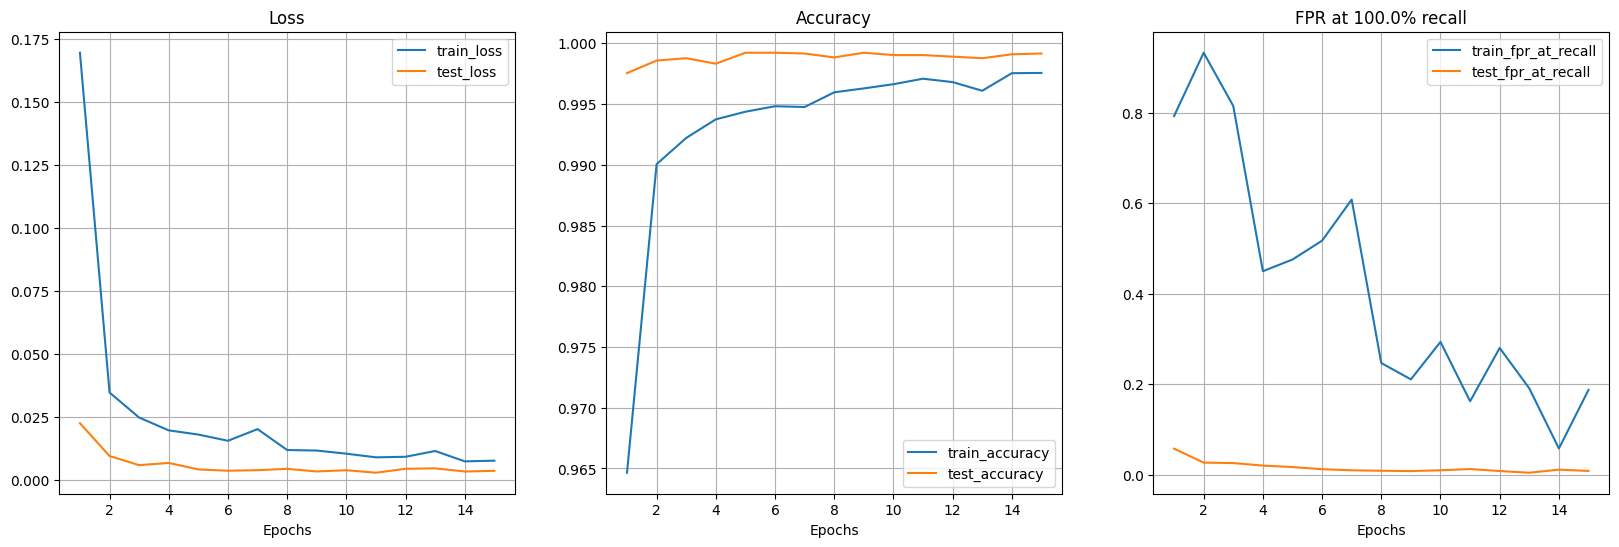

[INFO] Saving model to: ..\models\effnetb0_classif_epoch15.pth
[INFO] Saving model to: ..\models\effnetb0_classif.pth


In [7]:
model_type="effnetb0_classif"
EPOCHS = 15
LR = 0.00001
ACCUMULATION_STEPS = 1
model_name = f"{model_type}"
effnetb0_cl_model_name = model_name + ".pth"
    
optimizer = torch.optim.AdamW(
    params=effnetb0_cl_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=1e-4
    )

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=effnetb0_cl_model,
    save_best_model=True,
    mode="all", # all epochs to be saved
    device=device)

effnetb0_cl_model_results = train.fit(
    target_dir=model_dir,
    model_name=effnetb0_cl_model_name,
    train_dataloader=train_dataloader_effb0,
    test_dataloader=test_dataloader_effb0,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=TARGET_RECALL,
    scheduler=None,
    epochs=EPOCHS,
    amp=False, #amp equal to True results in inestability
    enable_grad_clipping=False
    )

In [8]:
effnetb0_cl_model_results

epoch  train_loss  train_acc  test_loss  test_acc  train_time [s]  \
0       1    0.169493   0.964650   0.022543  0.997546      353.306113   
1       2    0.034706   0.990051   0.009522  0.998580      348.941472   
2       3    0.024777   0.992209   0.005903  0.998773      354.416949   
3       4    0.019697   0.993741   0.006783  0.998321      351.822688   
4       5    0.018038   0.994367   0.004208  0.999225      356.220371   
5       6    0.015566   0.994820   0.003686  0.999225      347.227794   
6       7    0.020197   0.994756   0.003907  0.999161      361.985281   
7       8    0.011905   0.995964   0.004438  0.998838      353.920741   
8       9    0.011694   0.996288   0.003404  0.999225      355.447569   
9      10    0.010450   0.996633   0.003887  0.999032      361.882303   
10     11    0.008999   0.997086   0.002898  0.999032      376.509429   
11     12    0.009223   0.996806   0.004452  0.998902      381.265735   
12     13    0.011523   0.996094   0.004648  0.998773      369.816803   
13     14    0.007411   0.997540   0.003379  0.999096      354.727321   
14     15    0.007670   0.997561   0.003652  0.999161      359.070673   

    test_time [s]       lr  train_fpr_at_recall  test_fpr_at_recall  
0       67.584952  0.00001             0.792450            0.057725  
1       71.720142  0.00001             0.932452            0.026921  
2       68.144669  0.00001             0.814778            0.025912  
3       67.145153  0.00001             0.449770            0.020351  
4       67.928626  0.00001             0.475567            0.017078  
5       69.041296  0.00001             0.517223            0.012361  
6       69.875392  0.00001             0.608003            0.009923  
7       67.050227  0.00001             0.246907            0.008916  
8       70.167405  0.00001             0.210814            0.008207  
9       77.424113  0.00001             0.293628            0.009995  
10      74.048581  0.00001             0.162450            0.012682  
11      76.121756  0.00001             0.280162            0.008319  
12      68.307717  0.00001             0.190905            0.004593  
13      67.283276  0.00001             0.058133            0.011393  
14      68.268639  0.00001             0.187502            0.008532

# 6. Making Predictions

## 6.1. Evaluation Functions

In [70]:
def find_roc_threshold_tpr(y, y_pred, value_target):
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
       
    y                     # Real labels
    y_pred                # Predicted labels
    value_target          # False positive rate value
    
    Returns:
    
    threshold             # Threshold value
    true_positive_rate   # True positive rate value
    """

    fpr, tpr, thr = roc_curve(y, y_pred)

    closest_index = np.argmin(np.abs(tpr - value_target))

    threshold = thr[closest_index]
    false_pos_rate = fpr[closest_index]

    return threshold, false_pos_rate

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

def plot_class_distribution(y, y_pred):
    """
    This function plots the statistical distrution of the two predicted classes.
    """
    df = pd.DataFrame({'Predicted': list(y_pred), 'Real': list(y)})
    df.Predicted = df.Predicted.astype(float)
    df.Real = df.Real.astype(int)
    sns.kdeplot(data=df, x='Predicted', hue='Real', fill=True, alpha=0.2, linewidth=1.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Values for Each Class')
    plt.legend(labels=['It\'s Food: YES', 'It\'s Food: NO'])
   # plt.show()

## 6.2. Predict and Evaluate the Last-epoch Model

In [20]:
def predict(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            output_type: str="softmax",
            device: torch.device="cuda" if torch.cuda.is_available() else "cpu"
            ) -> torch.Tensor:
    """
    Predicts classes for a given dataset using a trained model.

    Args:
        model (torch.nn.Module): A trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): The dataset to predict on.
        output_type (str): The type of output to return. Either "softmax", "logits", or "argmax".
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (list): All of the predicted class labels represented by prediction probabilities (softmax)
    """

    # Check output_max
    valid_output_types = {"softmax", "argmax", "logits"}
    assert output_type in valid_output_types, f"Invalid output_max value: {output_type}. Must be one of {valid_output_types}"

    y_preds = []
    model.eval()
    model.to(device)
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):

            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            
            # Do the forward pass
            y_logit = model(X)

            if output_type == "softmax":
                y_pred = torch.softmax(y_logit, dim=1)
            elif output_type == "argmax":
                y_pred = torch.argmax(y_logit, dim=1).argmax(dim=1)
            else:
                y_pred = y_logit

            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())

    # Concatenate list of predictions into a tensor
    return torch.cat(y_preds)

In [12]:
# First, check out that the save model can be loaded
effnetb0_cl_model_last_epoch, _ = create_effnetb0(
    transfer_learning=False,
    class_names=class_names
    )

# Load the state dictionary
state_dict = torch.load(model_dir / "effnetb0_classif.pth", map_location=device)

# Load the state dictionary into the model
effnetb0_cl_model_last_epoch.load_state_dict(state_dict)

# And a summary
summary(effnetb0_cl_model_last_epoch,
        input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

C:\Users\ssre_\AppData\Local\Temp\ipykernel_23784\1912384571.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_dir / "effnetb0_classif.pth", 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 2]              --                   True
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 16, 112

In [34]:
# Make predictions
y_pred = predict(
    model=effnetb0_cl_model_last_epoch,
    dataloader=test_dataloader_effb0,
    device=device
    )[:,1].cpu().tolist()

Making predictions:   0%|          | 0/242 [00:48<?, ?it/s]

In [35]:
# Get the true labels
y_test = test_dataloader_effb0.dataset.targets

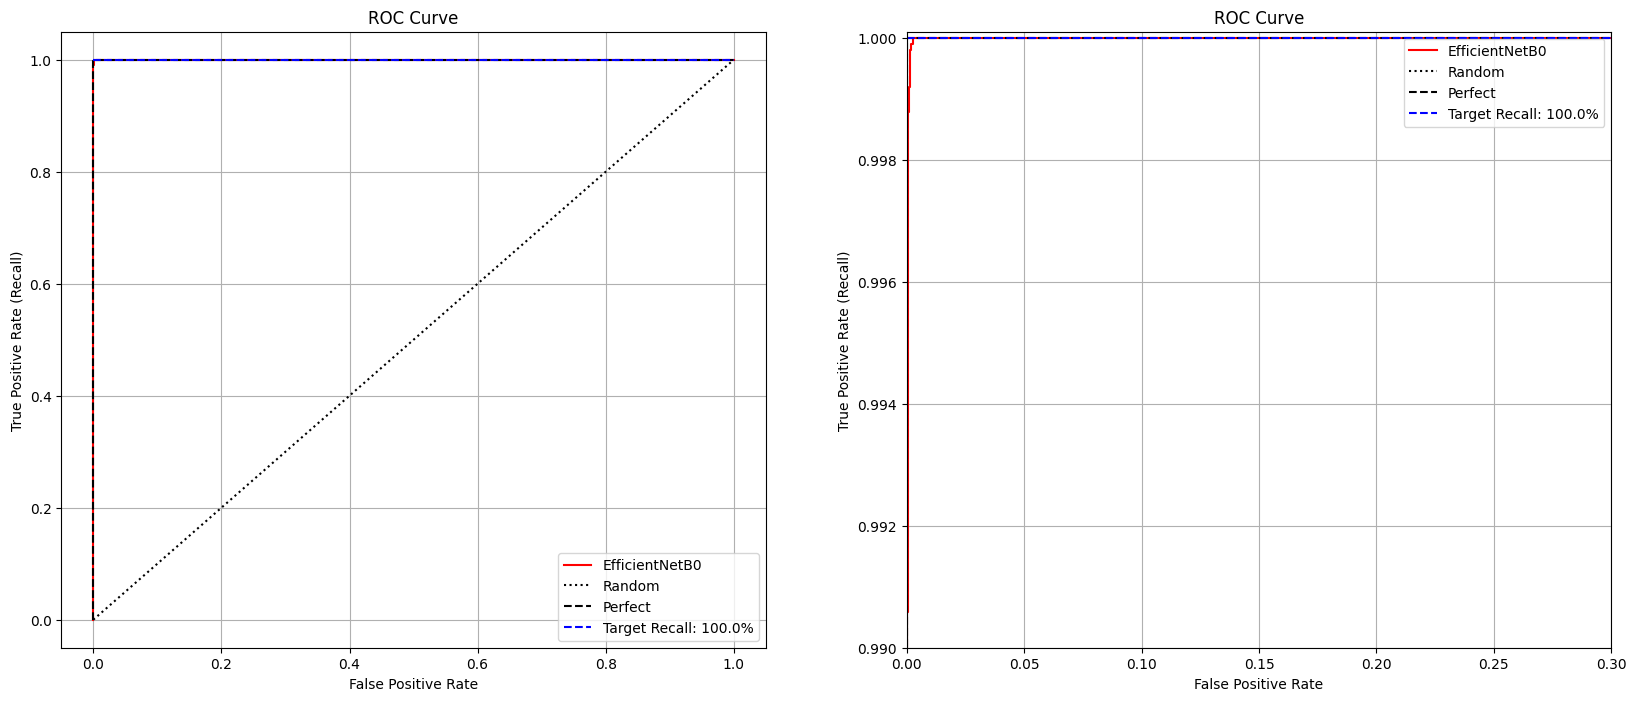

In [37]:
# Evaluate the model for a target recall of 1.0
TARGET_RECALL = 1.0
fpr, tpr, thr_roc = roc_curve(y_test, y_pred)
recall_label=f"Target Recall: {100*TARGET_RECALL}%"

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
plt.plot(fpr, tpr, 'r-', label = 'EfficientNetB0')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[TARGET_RECALL, TARGET_RECALL],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()

ax = fig.add_subplot(122)
plt.plot(fpr, tpr, 'r-', label = 'EfficientNetB0')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[TARGET_RECALL, TARGET_RECALL],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim(0.0, 0.3)
plt.ylim(0.99, 1.0001)
plt.grid()
plt.savefig(os.path.join('../images', 'roc_classif.png'), dpi=600)
plt.show()

In [38]:
# Compute roc auc score
roc_auc_model = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {round(roc_auc_model,3)}")

ROC AUC Score: 1.0


As observed, the ROC curve is almost perfect.

In [39]:
# Compute the threshold to achieve a TARGET_RECALL
thr, fpr = find_roc_threshold_tpr(y_test, y_pred, TARGET_RECALL)
print(f"Threshold for {round(100*TARGET_RECALL, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

Threshold for 100.0% recall: 0.4209151566028595
False Positive Rate: 0.27%


Normalized confusion matrix


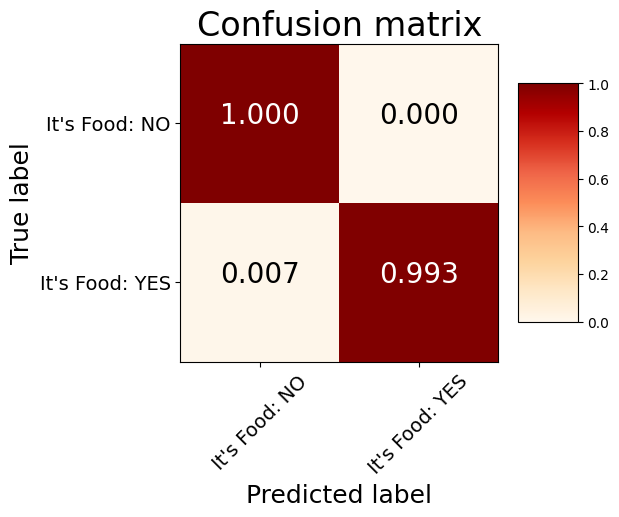

In [76]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred >= (thr))
plot_confusion_matrix(cm,
                      ['It\'s Food: NO', 'It\'s Food: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))
plt.savefig(os.path.join('../images', 'confusion_classif_nofalsenegatives_epoch15.png'), dpi=600)

With a target recall of 100%, a very few non-food images (0.27%) pass througth the classification model and will be misclassified. Alternatively, the recall rate could be reduced a little bit to avoid false positives.

Threshold for 99.3% recall: 0.9981166124343872
False Positive Rate: 0.0%
Normalized confusion matrix


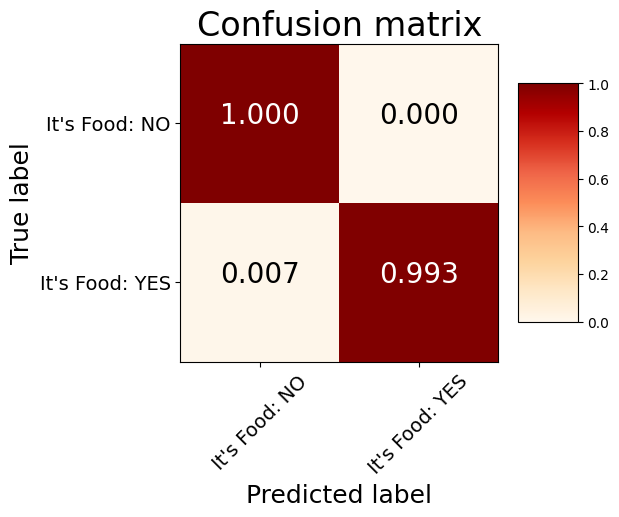

In [75]:
# Compute the threshold to achieve a TARGET_RECALL
TARGET_RECALL = 0.993
thr, fpr = find_roc_threshold_tpr(y_test, y_pred, TARGET_RECALL)
print(f"Threshold for {round(100*TARGET_RECALL, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred >= (thr))
plot_confusion_matrix(cm,
                      ['It\'s Food: NO', 'It\'s Food: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))
plt.savefig(os.path.join('../images', 'confusion_classif_nofalsepositives_epoch15.png'), dpi=600)

## 6.3. Predict and Evaluate the Model with the Lowest FPR

In [45]:
# Evaluate the epoch with the lowest FPR on the test dataset: epoch 13
EPOCH_FPR = 13
# Load the model
effnetb0_cl_model_eval_epoch, _ = create_effnetb0(
    transfer_learning=False,
    class_names=class_names
    )

# Load the state dictionary
state_dict = torch.load(model_dir / f"effnetb0_classif_epoch{EPOCH_FPR}.pth", map_location=device)

# Load the state dictionary into the model
effnetb0_cl_model_eval_epoch.load_state_dict(state_dict)

# Predict
y_pred = predict(model=effnetb0_cl_model_eval_epoch,
                 dataloader=test_dataloader_effb0)[:,1].cpu().tolist()

C:\Users\ssre_\AppData\Local\Temp\ipykernel_23784\2343638339.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_dir / f"effnetb0_classif_epoc

Making predictions:   0%|          | 0/242 [00:49<?, ?it/s]

Threshold for 99.3% recall: 0.9981166124343872
False Positive Rate: 0.0%
Normalized confusion matrix


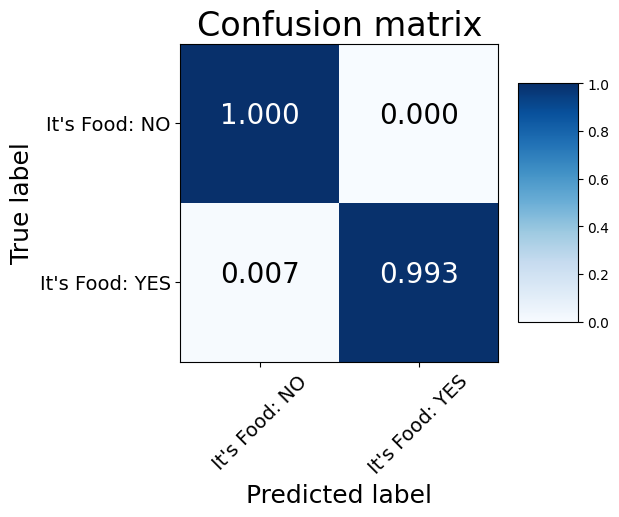

In [74]:
# Compute the threshold to achieve a TARGET_RECALL
TARGET_RECALL = 0.993
thr, fpr = find_roc_threshold_tpr(y_test, y_pred, TARGET_RECALL)
print(f"Threshold for {round(100*TARGET_RECALL, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred >= (thr))
plot_confusion_matrix(cm,
                      ['It\'s Food: NO', 'It\'s Food: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues,
                      figsize=(6,6))
plt.savefig(os.path.join('../images', f'confusion_classif_nofalsepositives_epoch{EPOCH_FPR}.png'), dpi=600)

## 6.4. Class Distribution Plot

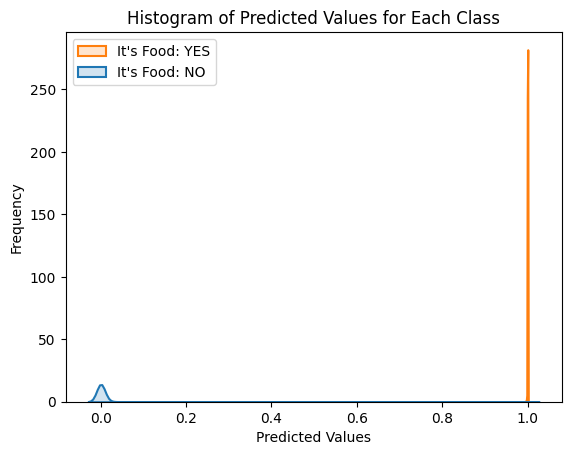

In [71]:
# Plot class distribution
plot_class_distribution(y_test, y_pred)
plt.savefig(os.path.join('../images', 'distribution_classif.png'), dpi=600)

As can be seen in the figure, both classes can be (almost) perfectly classified by the model.